# Introduction to image simulation with abTEM

This tutorial is a short introduction to image simulation with abTEM. The tutorial covers some basic principles and presents examples for CBED and STEM image simulation. For more in depth information, and information on other simulation modes, see the following resources:

* [The abTEM walkthrough](https://abtem.readthedocs.io/en/latest/walkthrough/introduction.html)
* [Quickstart examples](https://github.com/jacobjma/abTEM/tree/master/examples)
* [Examples repository](https://github.com/jacobjma/abTEM/tree/master/examples)

### Contents:

1. <a href='#import'> Import atomic model
2. <a href='#potentials'> Creating Potentials with the IAM
3. <a href='#waves'> The Waves object
4. <a href='#probes'> Creating Probe wave functions
5. <a href='#multislice'> Multislice simulation with Probe
6. <a href='#scan'> Scanned multislice simulation 
7. <a href='#frozen_phonons'> The frozen phonon model
8. <a href='#prism'> Large STEM simulation with PRISM

### Authors:
* 02/05/2022 Jacob Madsen - For HyperSpy workshop at ePSIC 2022

In [1]:
%matplotlib notebook

import abtem as ab
import ase
import numpy as np
import matplotlib.pyplot as plt

print('Tested with abTEM v1.0.0beta32. Your current version:', ab.__version__)

Tested with abTEM v1.0.0beta32. Your current version: 1.0.0beta32


## Import atomic model <a id='import'></a>

To start running image simulations, we need an atomic model. Creating an atomic model is covered in "atomic_models_with_ase.ipynb", if you do not have the file "my_atoms.cif", please run that notebook first.

## Creating `Potential`'s with the IAM <a id='potentials'></a>
An electron beam interacts with a specimen through the Coulomb potential. Typically, the indepedent atom model (IAM) is used to model the potential, in this model the potential is calculated as a superposition of atomic potentials, this model is used when creating a standard `Potential` object. 

To define a `Potential`, we need to provide an `ASE` atoms object, a sampling rate (or pixel size) in $x$ and $y$, and a slice thickness in the $z$-direction (propagation direction). 

The multislice algorithm is only accurate in the limit of thin slices, however, thin slices also increases computational cost. A sensible value for the slice thickness is typically between $0.5 \ Å$ and $2 \ Å$.

The `.build` method is available for many simulation objects. This method will convert a simulation object into a static array-based object.

`abTEM` has some direct integration with `hyperspy`. Hence, some objects can be converted directly to `hyperspy` signals.

Navigation axis name,size,index,offset,scale,units
z,32,0,0.0,1.9951375,Å
Signal axis name,size,,offset,scale,units
y,234,,0.0,0.05006410256410256,Å
x,221,,0.0,0.04997737556561086,Å


We can use the `.plot` method introduced earlier in the workshop.

<IPython.core.display.Javascript object>


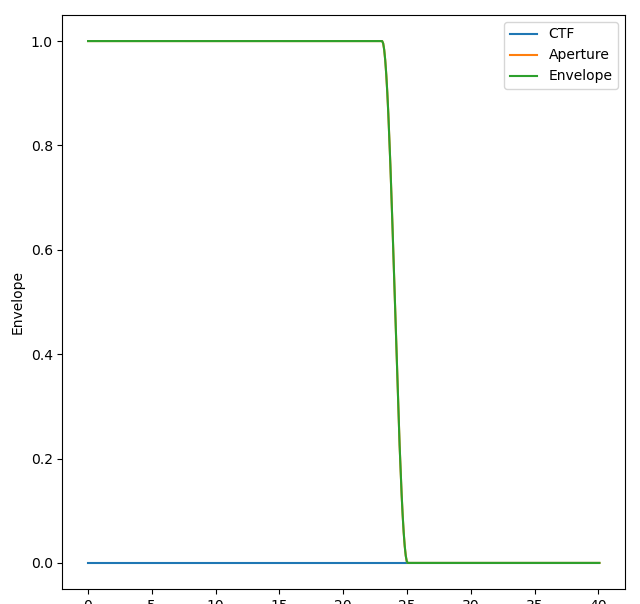

## The `Waves` object <a id='waves'></a>
The `Waves` object wraps a complex numpy array representing an arbitrary 2D wave function on a grid. Here we show how to define a plane wave on a $512 \times 512$ grid, a lateral extent of $10\times 10$ $\mathrm{Å}^2$ and an energy of 300 keV.

The complex array can be accessed through the `array` property. 

True

The real-space sampling in $x$ and $y$ of the wave function, is calculated by dividing the _extent_ by the number of _grid points_. The properties related to the grid, i.e. the extent, grid points and sampling can be accessed as:

In [10]:
print('extent: {:.1f} x {:.1f} Å^2'.format(*waves.extent))

print('gpts: {:} x {}'.format(*waves.gpts))

print('sampling: {:.2f} x {:.2f} Å^2'.format(*waves.sampling))

extent: 10.0 x 10.0 Å^2
gpts: 512 x 512
sampling: 0.02 x 0.02 Å^2


The maximum scattering angle represented in a simulation depends on the real space sampling and electron energy.

In [11]:
print('maximum scattering angles: {:.1f} mrad, {:.1f} mrad'.format(*waves.cutoff_scattering_angles))

maximum scattering angles: 335.7 mrad, 335.7 mrad


<div class= "alert alert-info">

**Note: Real-space sampling**

The real-space sampling is important because it controls the accuracy of the simulation at high scattering angles. The sampling defines the maximum spatial frequency $k_{max}$ via the formula:

$$ k_{max} = \frac{1}{2p} \quad , $$

where $p$ is the real-space sampling distance. To counteract aliasing artifacts due to the periodicity assumption of a discrete Fourier transform, abTEM supresses spatial frequencies above 2 / 3 of the maximum scattering angle, further reducing the maximum effective scattering angle by a factor of 2 / 3. Hence the maximum scattering angle $\alpha_{max}$ is given by:

$$ \alpha_{max} = \frac{2}{3}\frac{\lambda}{2p} \quad , $$

where $\lambda$ is the relativistic electron wavelength. 
</div>

## Creating `Probe` wave functions <a id='probes'></a>
In STEM, the wave function is a focused beam of electrons. The convention used in abTEM is a probe defined by

$$
    \phi(\mathbf{k}, \mathbf{r}_0) = A(k) \exp(-i \chi(\mathbf{k})) \exp(-i 2 \pi \mathbf{k} \cdot \mathbf{r}_0) \quad ,
$$

where, $\mathbf{k}$ is the spatial frequency, $A(k)$ is the condenser aperture function and $\chi(\mathbf{k})$ is the phase error and $\mathbf{r}_0$ is the probe position.

If the microscope is well aligned then off-axis aberrations are small and the phase error is dominated by defocus and spherical aberration

$$
    \chi(k) \approx \frac{2\pi}{\lambda}\left( \frac{\lambda^2 k^2}{2} \Delta f + \frac{\lambda^4 k^4}{4} C_s \right) \quad ,
$$

where $\Delta f$ is the defocus and $C_s$ is the third order spherical aberration. See our [walkthrough section](https://abtem.readthedocs.io/en/latest/walkthrough/05_contrast_transfer_function.html) for more information.

We create a probe with a sampling of $0.05 \ \mathrm{Å}$, an extent of $10\times 10$ $\mathrm{Å}^2$, an energy of $100 \ \mathrm{keV}$, a convergence semiangle of $25 \ \mathrm{mrad}$, and a defocus of $50 \ \mathrm{Å}$. 

The [Contrast Transfer Function](https://en.wikipedia.org/wiki/High-resolution_transmission_electron_microscopy#The_phase_contrast_transfer_function) of the probe may be shown as below.

<IPython.core.display.Javascript object>


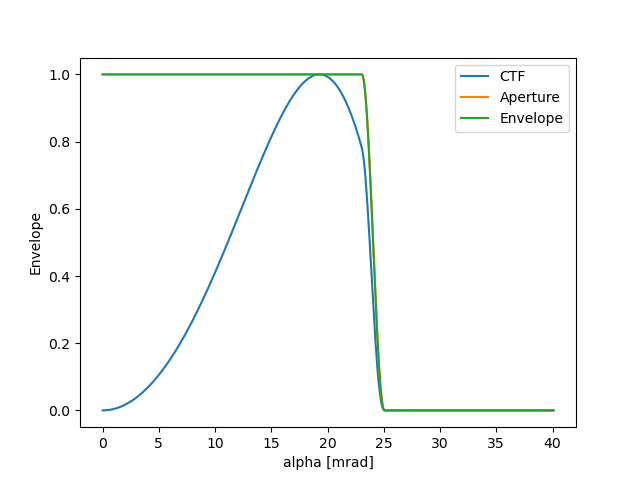

We may want to `.build` the probe to obtain an array representation.

The wave function intensity can be shown in real or Fourier space using the `.intensity` or `.diffraction_pattern` method and showing the resulting `Measurement`.

<IPython.core.display.Javascript object>


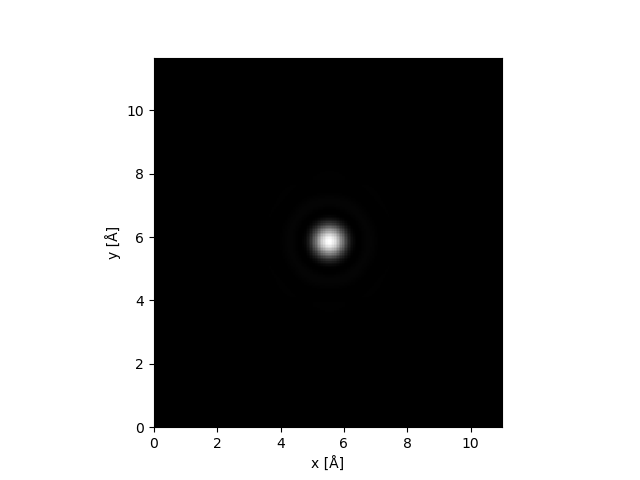

<IPython.core.display.Javascript object>


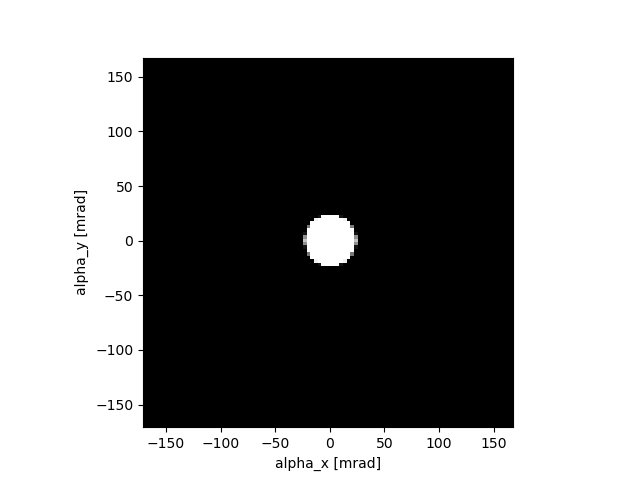

## Multislice simulation with `Probe` (CBED) <a id='multislice'></a>
We use the multislice algorithm to propagate the probe through the potential. We can choose where to place the probe by setting the `positions`.

Potential:   0%|          | 0/32 [00:00<?, ?it/s]

Multislice:   0%|          | 0/32 [00:00<?, ?it/s]

We show the `.intensity` and `.diffraction_pattern` as above.

<IPython.core.display.Javascript object>


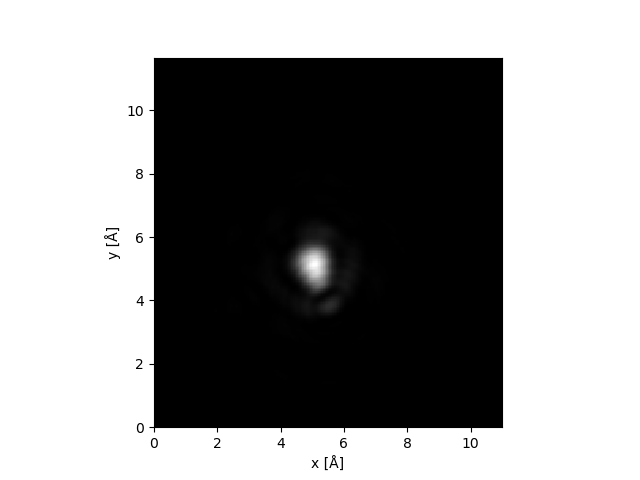

<IPython.core.display.Javascript object>


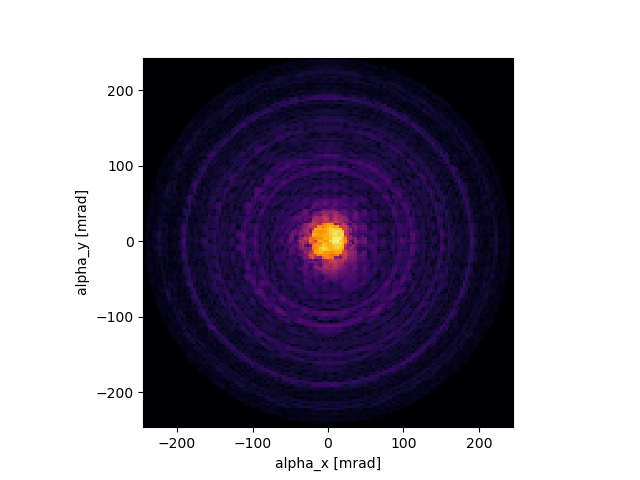

CBED is often used for determining sample the thickness by comparing an experiment to a thickness series. The current version of abTEM has no dedicated function for simulating a thickness series, however, it is easy to create one using a loop.

We propagate the probe wave function one slice at a time by looping over potential slices, after each slice a measurement is saved. Lastly, all the measurements are stacked in a single object.

The measurement is converted to a hyperspy signal. In the current version of abTEM the axes are not automatically converted, hence we need to set the axes manually.

Navigation axis name,size,index,offset,scale,units
thickness,32,0,0.0,2.0,Å
Signal axis name,size,,offset,scale,units
alpha_y,108,,-170.61679345575632,3.1595702491806725,mrad
alpha_x,102,,-170.9128701199487,3.3512327474499743,mrad


<IPython.core.display.Javascript object>


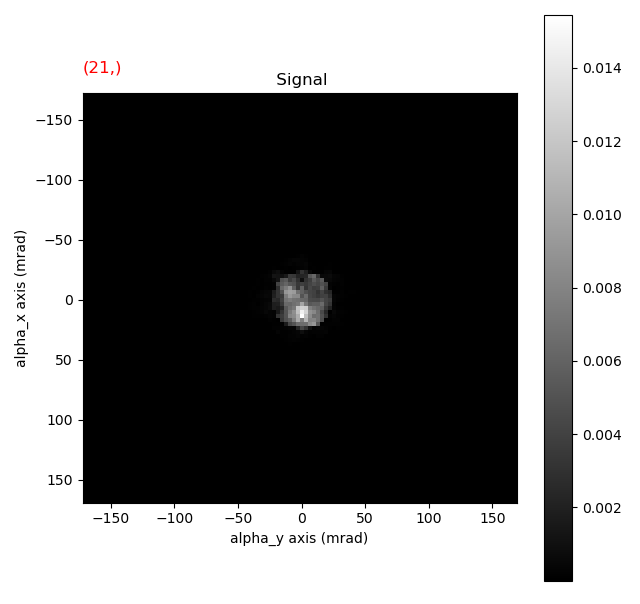

## Scanned multislice simulation (HAADF) <a id='scan'></a>

Scanning imaging modes such as STEM works by rastering an electron probe across a sample pixel by pixel and recording the scattering signal. 

We create a grid scan and set the sampling (probe step size) to the Nyquist sampling of the probe. 

<div class= "alert alert-info">

**Note: Scan sampling**

The scan sampling should not be confused with the wave function sampling. The scan sampling in any integrated STEM imaging mode should generally be set to the [Nyquist sampling rate](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem). The image may be interpolated to the typically much higher experimental sampling rate.

</div>

In experiments the wave functions are not directly detected. Correspondingly, in abTEM the exit waves are "detected" using a detector object. There are several different types of detectors, the most basic, the `AnnularDetector`, may be used for bright-field, medium- or high-angle annular dark-field microscopy. Depending on the integration region.

The integration region is given by an inner and outer radius in mrad; below we create three different types of detectors. We show the integration region of the HAADF detector.

<IPython.core.display.Javascript object>


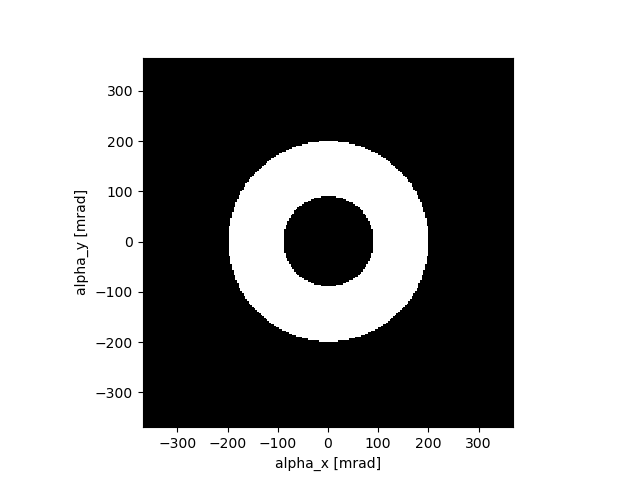

The scanned multislice simulations are started as below, a progress bar is shown to indicate how long time the simulation will take. It took about 35s on my 8-core\@2.6 GHz laptop.

Potential:   0%|          | 0/32 [00:00<?, ?it/s]

Scan:   0%|          | 0/960 [00:00<?, ?it/s]

We show the measurement as earlier.

<IPython.core.display.Javascript object>


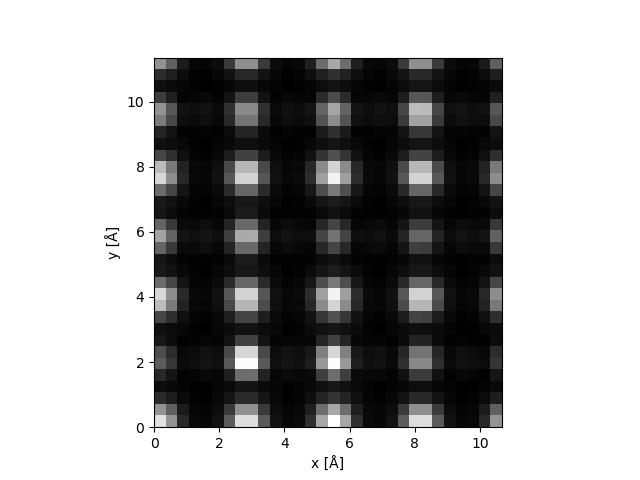

It is usually necessary to do some post-processing on the simulated images. In particular, we may want to resample the images. 

We usually also want to add a gaussian blur to simulate partial spatial coherence (i.e. source size). Partial temporal coherence (energy spread) is more complicated to include, and will not be covered here.

<IPython.core.display.Javascript object>


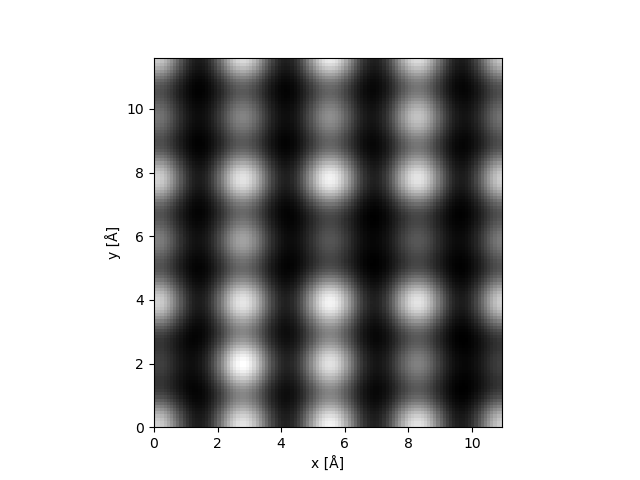

## The frozen phonon model <a id='frozen_phonons'></a>
The atoms in any real material at a particular instance of time are not exactly located at their symmetrical lattice points due to thermal and zero-point vibrations. In the Frozen phonon approximation, the effects of thermal vibrations is simulated by the _intensities_ averaged over several different configurations of atoms with different random offsets. 

To simulate frozen phonons the `Atoms` are wrapped with a `FrozenPhonons` object. To define a `FrozenPhonons` object we also need to provide the magnitude of the thermal vibrations for each atomic species.

The magnitude of thermal vibrations are often tabulated as the Debye-Waller $B$ factor, the standard deviation of the atomic positions, $\sigma$, is related as:  

$$
\sigma = \sqrt{\frac{B}{8\pi^2}} \quad .
$$

Obtaining the right magnitude of thermal vibrations for any particular material, is not always trivial, here we just use the same value 0.1 Å for all atomic numbers. We set the number random structures in the thermal ensemble to 32.

We can draw a particular frozen phonon configuration by iterating.

<IPython.core.display.Javascript object>


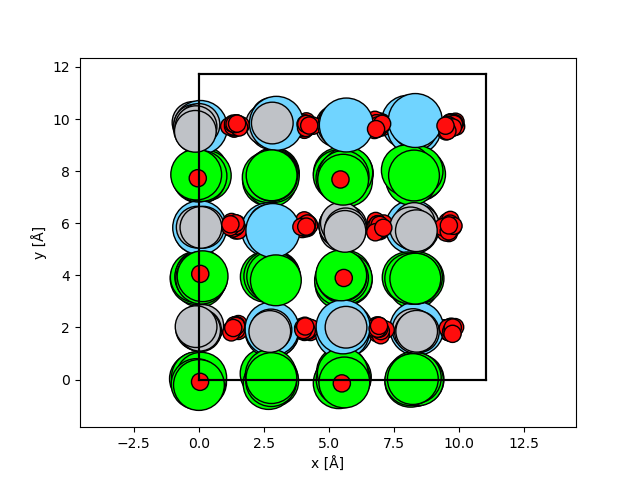

The potential can be created as above, we just provide the frozen phonons instead of the atoms. 

The potential object can be used in the same way as above, here we do a CBED simulation, since the HAADF simulation is too time-consuming for a demo.

TDS:   0%|          | 0/32 [00:00<?, ?it/s]

Multislice:   0%|          | 0/32 [00:00<?, ?it/s]

Potential:   0%|          | 0/32 [00:00<?, ?it/s]

The output wave function is 3d, the first dimension is the frozen phonon ensemble dimension. 

(32, 147, 156)

To finalize the diffraction pattern we take the mean over the ensemble dimension.

<IPython.core.display.Javascript object>


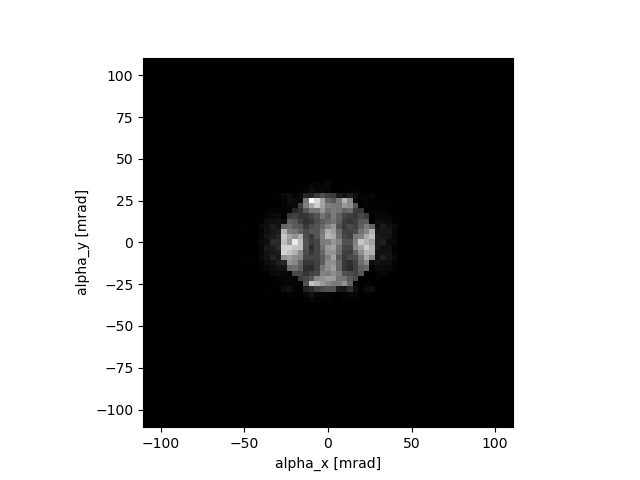

(<AxesSubplot:xlabel='alpha_x [mrad]', ylabel='alpha_y [mrad]'>,
 <matplotlib.image.AxesImage at 0x17bb4b8e710>)

Note: some other imaging modes will average over frozen phonons by default to conserve memory.

## Large STEM simulation with PRISM <a id='prism'></a>
Multslice simulations of STEM images can be very slow because the scattering of the electron probe is calculated from scratch at each pixel of the image. An alternative is to use the [PRISM algorithm](https://prism-em.com). PRISM almost always provides a decent speed-up for images with many probe positions, and allows for huge speedups, at a modest cost to accuracy, by using Fourier interpolation.

We import the moderately large model of a nanoparticle on carbon that we constructed in "atomic_models_with_ase.ipynb".

In [36]:
from ase.io import read

cluster = read('cluster_on_carbon.cfg')

print('Number of atoms: {} \nCell: {:.2f} x {:.2f} x {:.2f}'.format(len(cluster), *np.diag(cluster.cell)))

Number of atoms: 23013 
Cell: 49.98 x 49.98 x 70.04


In abTEM, the PRISM algorithm can be used by simply exchanging the `Probe` for the `SMatrix`. However, there is one additional keyword the user has to know about, namely interpolation.

Increasing the interpolation decreases the number of plane waves necessary in the plane wave expansion of the probe, hence lowering both time and memory consumption. The necessary price is that the interpolation factor also decreases the Fourier space sampling rate, i.e. the pixels of the detected diffraction patterns becomes larger.

We create potential, scan and a MAADF and pixelated detector as we have done before.

The simulation is run as before. We lower the maximum number of plane waves propagated simulataneously to lower the memory footprint slightly.

Potential:   0%|          | 0/36 [00:00<?, ?it/s]

Multislice:   0%|          | 0/149 [00:00<?, ?it/s]

Scan:   0%|          | 0/35344 [00:00<?, ?it/s]

The simulation took around 30 seconds on my 8-core\@2.6 GHz laptop. The same simulation is estimated to take 4 hours on the same system.

Lastly, we postprocess and show the MAADF image, as we have done before.

<IPython.core.display.Javascript object>


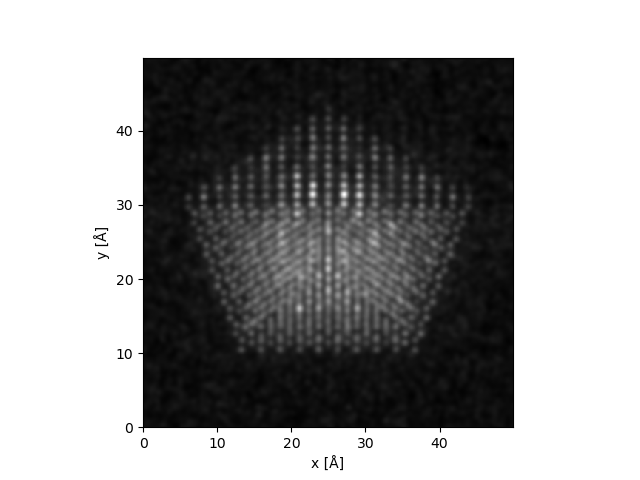